In [1]:
import pandas as pd
import pymc as pm
from datetime import timedelta
import sys
sys.path.append("..")
from src.analysis_utils import BrentOilAnalysis
from src.model_engine import BrentOilBayesianModel

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


In [ ]:
events_df = pd.read_csv('../data/processed/researched_events.csv')
events_df['Date'] = pd.to_datetime(events_df['Date'])

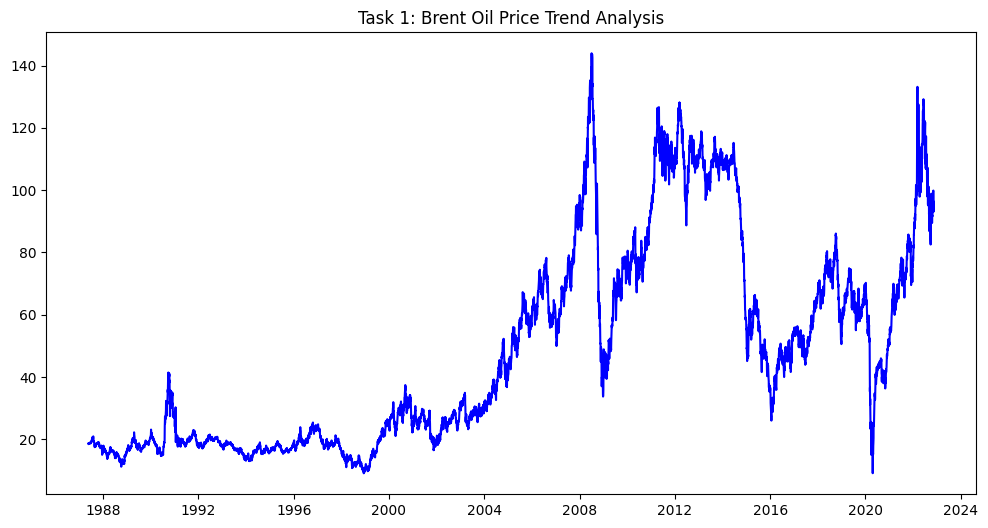

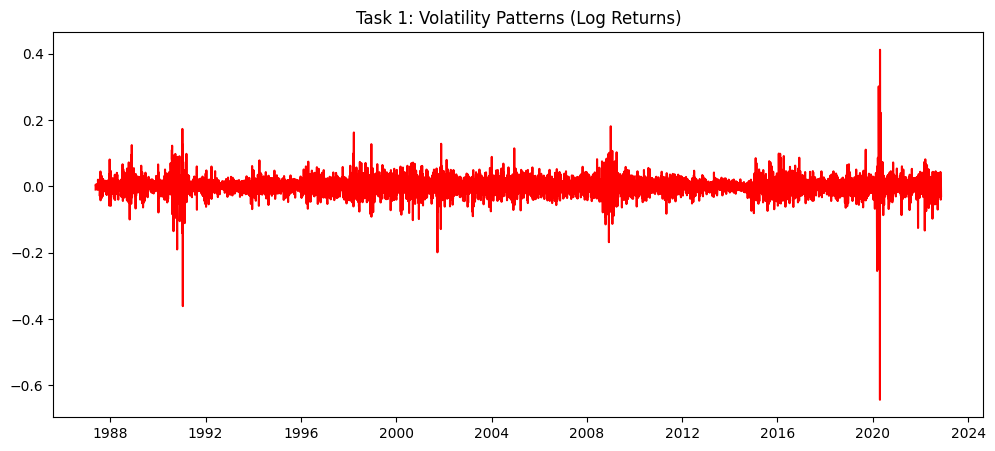

In [ ]:
analyzer = BrentOilAnalysis('../data/raw/BrentOilPrices.csv')
analyzer.plot_trend()         
analyzer.plot_volatility()    


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu_1, mu_2, sigma]


c:\Users\arwa\brent_oil_analysis\venv\Lib\site-packages\rich\live.py:260: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1016 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


         mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_1   99.458  0.863   97.885  101.157      0.023    0.023    1387.0   
mu_2   59.623  0.816   58.071   61.184      0.022    0.020    1389.0   
tau   115.836  1.686  113.000  118.000      0.124    0.197     255.0   

      ess_tail  r_hat  
mu_1    1271.0    1.0  
mu_2     968.0    1.0  
tau      143.0    1.0  


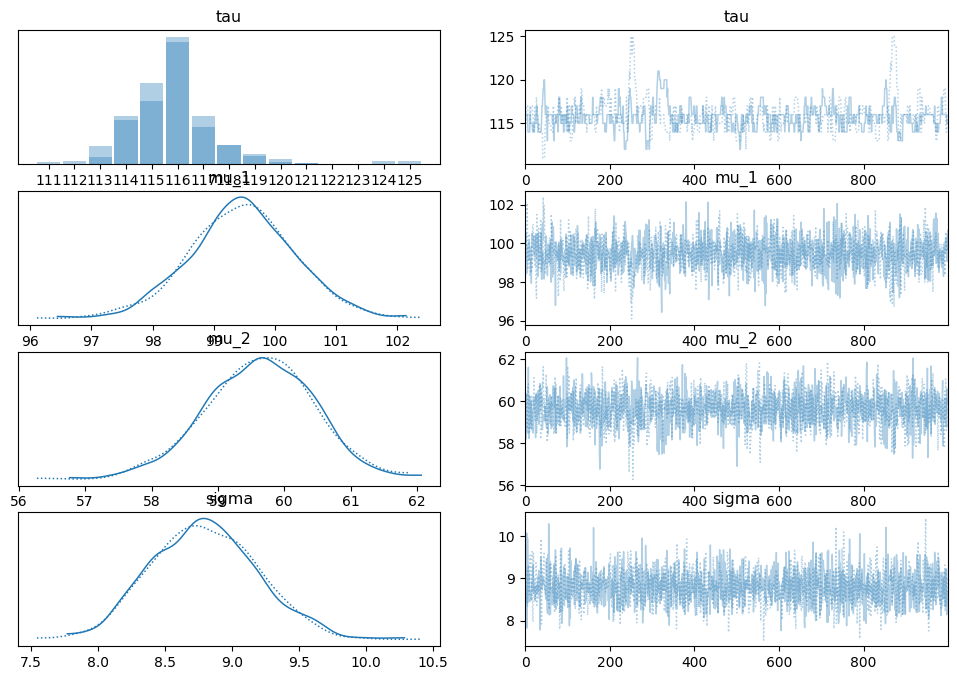

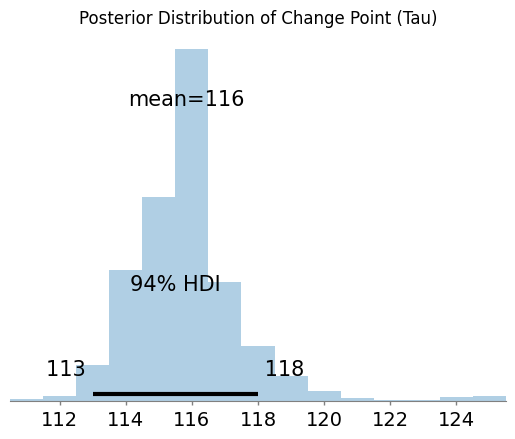

In [4]:
subset = analyzer.df.loc['2014-06-01':'2015-06-01', 'Price'] 

engine = BrentOilBayesianModel(subset.values)
engine.build_model()
with engine.model:
    trace = pm.sample(draws=1000, tune=500, cores=1, return_inferencedata=True)

engine.trace = trace
engine.interpret_outputs()

In [ ]:
tau_samples = trace.posterior['tau'].values.flatten()
tau_mode = int(pd.Series(tau_samples).mode()[0])
detected_date = pd.to_datetime(subset.index[tau_mode])
mu1_val = trace.posterior['mu_1'].mean().values
mu2_val = trace.posterior['mu_2'].mean().values
perc_change = ((mu2_val - mu1_val) / mu1_val) * 100

print(f"--- QUANTITATIVE IMPACT REPORT ---")
print(f"Detected Change Point: {detected_date.date()}")
print(f"Average Price Before: ${mu1_val:.2f}")
print(f"Average Price After: ${mu2_val:.2f}")
print(f"Percentage Change: {perc_change:.2f}%")

--- QUANTITATIVE IMPACT REPORT ---
Detected Change Point: 2014-11-13
Average Price Before: $99.46
Average Price After: $59.62
Percentage Change: -40.05%


In [ ]:
events_df = pd.read_csv('../data/processed/researched_events.csv')
print("\nClosest Researched Events:")
print(events_df.head()) 


Closest Researched Events:
         Date                   Event
0  1990-08-02     Iraq invades Kuwait
1  1997-07-02  Asian Financial Crisis
2  2001-09-11            9/11 Attacks
3  2003-03-20         Iraq War Begins
4  2008-07-11          Oil Price Peak


In [ ]:
def associate_and_quantify(detected_date, mu1, mu2, events_df):

    diff = mu2 - mu1
    perc_change = (diff / mu1) * 100
    direction = "increase" if diff > 0 else "decrease"
    events_df['Date'] = pd.to_datetime(events_df['Date'])
    events_df['days_diff'] = (events_df['Date'] - detected_date).dt.days.abs()
    closest_event = events_df.loc[events_df['days_diff'].idxmin()]
    
    print(f"--- TASK 2: ASSOCIATION & QUANTIFICATION ---")
    
    if closest_event['days_diff'] < 30:
        print(f"Hypothesis: The shift was likely triggered by: {closest_event['Event']}")
        print(f"Event Date: {closest_event['Date'].date()} | Detected Change: {detected_date.date()}")
    else:
        print("No specific event found in the 30-day window. Possible organic market shift.")
   
    report_sentence = (
        f"Following the period around {closest_event['Event']} ({closest_event['Date'].date()}), "
        f"the model detects a change point around {detected_date.date()}, with the average daily price "
        f"shifting from ${mu1:.2f} to ${mu2:.2f}, an {direction} of {abs(perc_change):.2f}%."
    )
    
    print("\nFINAL REPORT SENTENCE:")
    print(report_sentence)




In [11]:
associate_and_quantify(detected_date, mu1_val, mu2_val, events_df)

--- TASK 2: ASSOCIATION & QUANTIFICATION ---
Hypothesis: The shift was likely triggered by: OPEC Non-Cut Decision
Event Date: 2014-11-27 | Detected Change: 2014-11-13

FINAL REPORT SENTENCE:
Following the period around OPEC Non-Cut Decision (2014-11-27), the model detects a change point around 2014-11-13, with the average daily price shifting from $99.46 to $59.62, an decrease of 40.05%.
